<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-08-02 11:54:03.707579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

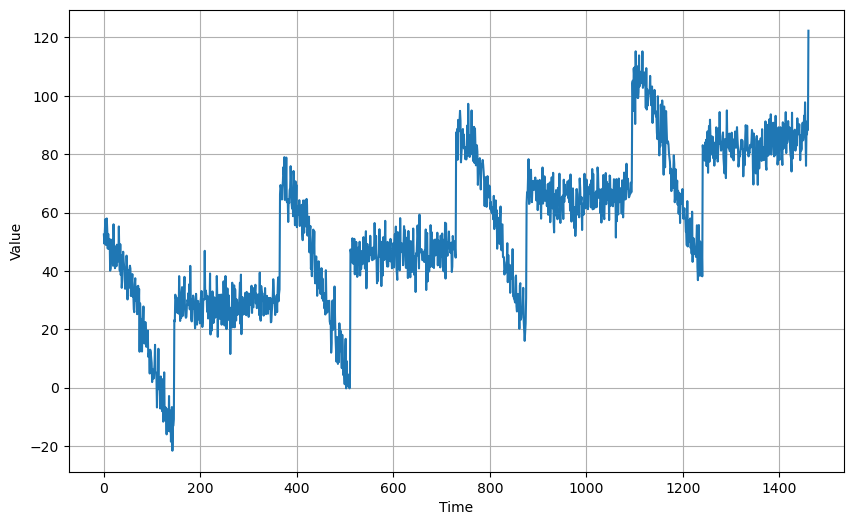

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
# Print shapes of feature and label
for window in dataset.take(1):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


2023-08-02 11:54:35.960296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-02 11:54:35.961285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1000]
	 [[{{node Placeholder/_0}}]]


## Build the Model

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routs its output back to the input. You will stack two of these layers in your model so the first one should have `return_sequences` set to `True`.

As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Normally, you can just a have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [9]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2023-08-02 11:54:53.795191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-02 11:54:53.795594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1000]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 2s 19ms/step - loss: 54.1451 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 43.2147 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 29.6805 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 20.5873 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 18.6687 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 18.1624 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 17.6192 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 17.0331 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 16.3971 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 15.7104 - lr: 2.8184e-08
Epoch 11/100
31/31 [==========

31/31 [==============================] - 0s 5ms/step - loss: 17.0296 - lr: 1.4125e-04
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 18.8536 - lr: 1.5849e-04
Epoch 86/100
31/31 [==============================] - 0s 5ms/step - loss: 16.7970 - lr: 1.7783e-04
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 17.4260 - lr: 1.9953e-04
Epoch 88/100
31/31 [==============================] - 0s 5ms/step - loss: 18.2479 - lr: 2.2387e-04
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 15.8427 - lr: 2.5119e-04
Epoch 90/100
31/31 [==============================] - 0s 5ms/step - loss: 16.3505 - lr: 2.8184e-04
Epoch 91/100
31/31 [==============================] - 0s 5ms/step - loss: 20.4327 - lr: 3.1623e-04
Epoch 92/100
31/31 [==============================] - 0s 5ms/step - loss: 18.7190 - lr: 3.5481e-04
Epoch 93/100
31/31 [==============================] - 0s 5ms/step - loss: 17.8831 - lr: 3.9811e-04
Epoch 94/100
31/31 [===

You can visualize the results and pick an optimal learning rate.

(1e-08, 0.001, 0.0, 50.0)

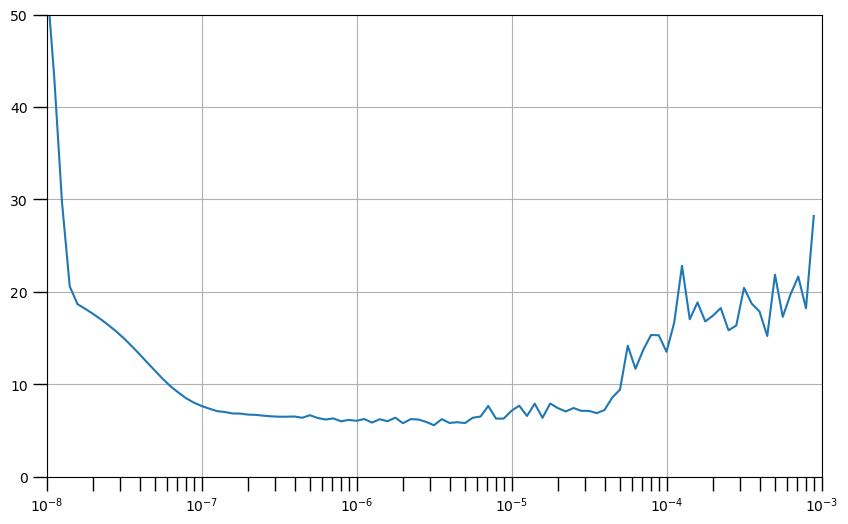

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

You can change the boundaries of the graph if you want to zoom in. The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

(1e-07, 0.0001, 0.0, 20.0)

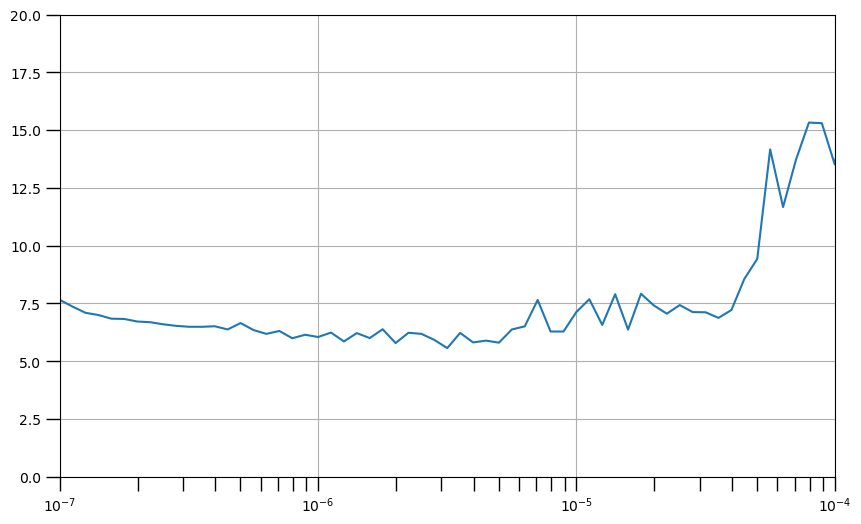

In [12]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

## Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to `1e-6`by default but feel free to change it.

In [13]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 6ms/step - loss: 30.6446 - mae: 31.1402
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 13.6775 - mae: 14.1673
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 9.4453 - mae: 9.9333
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 9.0990 - mae: 9.5875
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 8.8135 - mae: 9.3001
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 8.4805 - mae: 8.9667
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 8.0465 - mae: 8.5328
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 7.8186 - mae: 8.3057
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 7.6714 - mae: 8.1546
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 7.5651 - mae: 8.0486
Epoch 11/100
31/31 [==============================] - 0

31/31 [==============================] - 0s 7ms/step - loss: 5.1477 - mae: 5.6233
Epoch 88/100
31/31 [==============================] - 0s 6ms/step - loss: 4.9745 - mae: 5.4507
Epoch 89/100
31/31 [==============================] - 0s 6ms/step - loss: 5.0881 - mae: 5.5700
Epoch 90/100
31/31 [==============================] - 0s 6ms/step - loss: 5.1402 - mae: 5.6178
Epoch 91/100
31/31 [==============================] - 0s 6ms/step - loss: 5.1435 - mae: 5.6231
Epoch 92/100
31/31 [==============================] - 0s 6ms/step - loss: 5.1196 - mae: 5.5999
Epoch 93/100
31/31 [==============================] - 0s 6ms/step - loss: 5.0844 - mae: 5.5615
Epoch 94/100
31/31 [==============================] - 0s 7ms/step - loss: 5.0347 - mae: 5.5106
Epoch 95/100
31/31 [==============================] - 0s 7ms/step - loss: 4.9913 - mae: 5.4676
Epoch 96/100
31/31 [==============================] - 0s 7ms/step - loss: 4.9804 - mae: 5.4533
Epoch 97/100
31/31 [==============================] - 0s 7ms/st

## Model Prediction

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. You can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


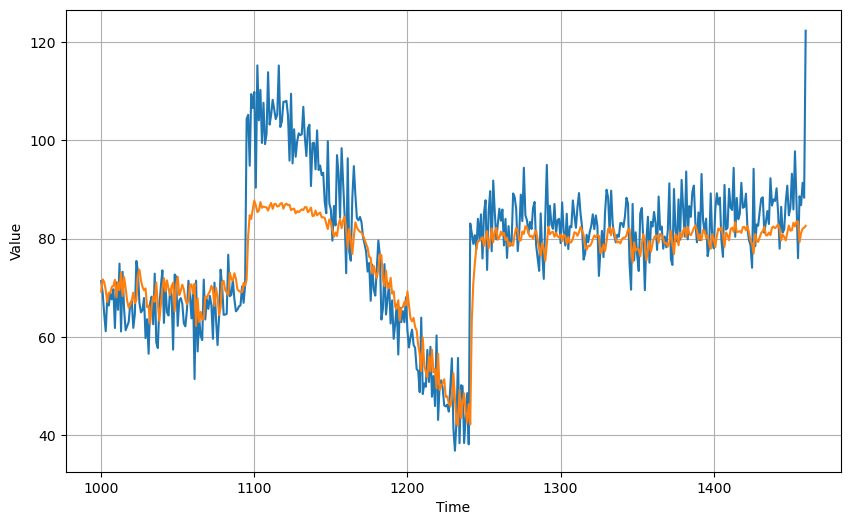

In [14]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, you can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. You will notice that it almost mirrors the `windowed_dataset()` function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

You can run the function below to use the function. Notice that the predictions are generated almost instantly.

*Note: You might notice that the first line slices the `series` at `split_time - window_size:-1` which is a bit different from the slower for-loop code. That is because we want the model to have its last prediction to align with the last point of the validation set (i.e. `t=1460`). You were able to do that with the slower for-loop code by specifying the for-loop's `range()`. With the more efficient function above, you don't have that mechanism so you instead just remove the last point when slicing the `series`. If you don't, then the function will generate a prediction at `t=1461` which is outside the validation set range.*

      1/Unknown - 0s 201ms/step

2023-08-02 11:56:49.243007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [480]
	 [[{{node Placeholder/_0}}]]
2023-08-02 11:56:49.243606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [480]
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 0s 4ms/step


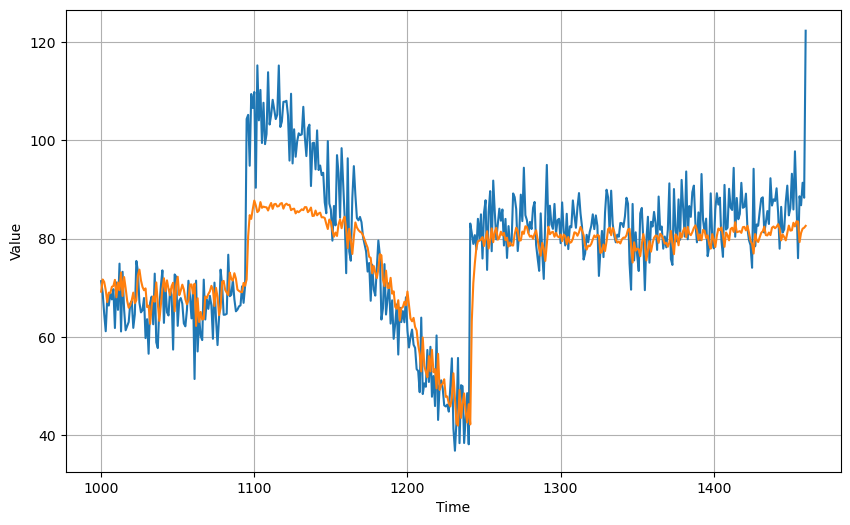

In [16]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the MSE and MAE. You can compare the results here when using other RNN architectures which you'll do in the next lab.

In [17]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

78.902626
6.534226
